In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import json
from imblearn.over_sampling import ADASYN

# PyCaret import
from pycaret.classification import *

In [3]:
# 1. Chargement du dataset
df = pd.read_csv("dataset_contribuables_non_conformite_fcfa.csv")

In [4]:
# 2. Suppression colonne inutile si présente
if 'contribuable_id' in df.columns:
    df.drop(columns=['contribuable_id'], inplace=True)

print("Informations sur le dataset :")
print(df.info())

print("\nValeurs manquantes par colonne avant nettoyage :")
print(df.isnull().sum())

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   revenu_annuel        55749 non-null  float64
 1   retards_paiement     55838 non-null  float64
 2   sanctions_passées    55815 non-null  float64
 3   secteur_activité     60000 non-null  object 
 4   chiffre_affaire      55825 non-null  float64
 5   localisation         60000 non-null  object 
 6   nb_controles         55754 non-null  float64
 7   niveau_risque        60000 non-null  object 
 8   prob_non_conformité  60000 non-null  float64
dtypes: float64(6), object(3)
memory usage: 4.1+ MB
None

Valeurs manquantes par colonne avant nettoyage :
revenu_annuel          4251
retards_paiement       4162
sanctions_passées      4185
secteur_activité          0
chiffre_affaire        4175
localisation              0
nb_controles           4246
niveau_ri

In [5]:
# 3. Nettoyage
df = df.drop_duplicates()

# Imputation valeurs manquantes dans colonnes numériques
numeric_cols = ['revenu_annuel', 'retards_paiement', 'sanctions_passées', 'chiffre_affaire', 'nb_controles']
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [6]:
# 4. Feature Engineering
df['ratio_revenu_ca'] = df['revenu_annuel'] / df['chiffre_affaire'].replace(0, np.nan)
df['ratio_revenu_ca'] = df['ratio_revenu_ca'].fillna(df['ratio_revenu_ca'].median())

df['interaction_retards_sanctions'] = df['retards_paiement'] * df['sanctions_passées']

print("\nValeurs manquantes après imputation :")
print(df.isnull().sum())


Valeurs manquantes après imputation :
revenu_annuel                    0
retards_paiement                 0
sanctions_passées                0
secteur_activité                 0
chiffre_affaire                  0
localisation                     0
nb_controles                     0
niveau_risque                    0
prob_non_conformité              0
ratio_revenu_ca                  0
interaction_retards_sanctions    0
dtype: int64


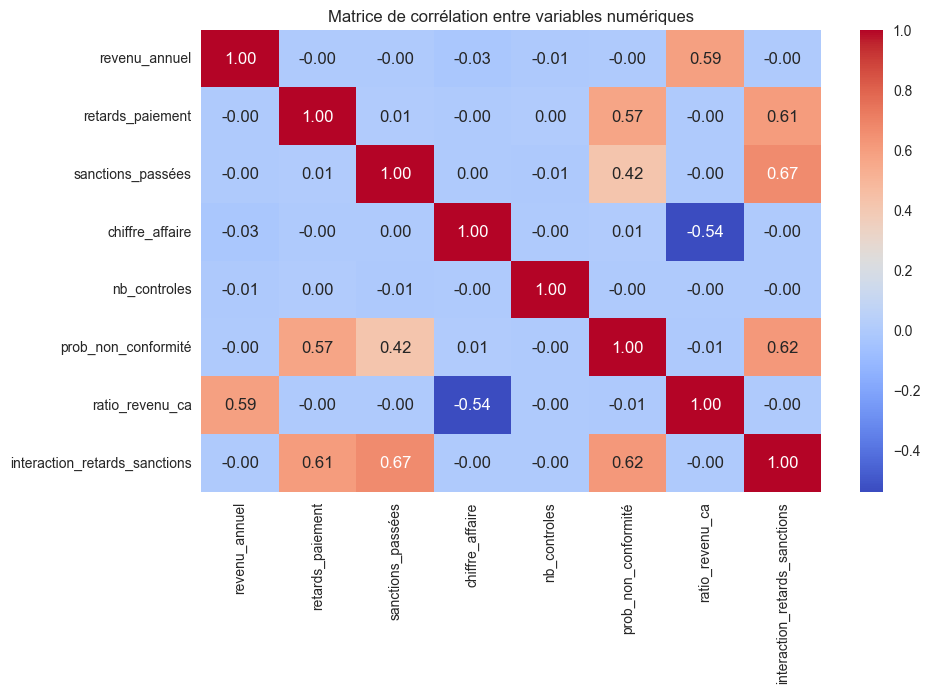

In [7]:
# 5. Analyse rapide des corrélations numériques
plt.figure(figsize=(10, 6))
num_cols_analysis = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[num_cols_analysis].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation entre variables numériques")
plt.show()

In [8]:
# 6. Préparation cible binaire : prob_non_conformité > seuil optimal
optimal_threshold = 0.5
df['target'] = (df['prob_non_conformité'] > optimal_threshold).astype(int)
print("Répartition des classes :")
print(df['target'].value_counts(normalize=True))

Répartition des classes :
target
0    0.563183
1    0.436817
Name: proportion, dtype: float64


In [10]:
# 7. Encodage variables catégoriques pour modèle sklearn
categorical_cols = ['secteur_activité', 'localisation', 'niveau_risque']
df_encoded = pd.get_dummies(df.drop(columns=['prob_non_conformité']), columns=categorical_cols, drop_first=True)

# Sauvegarde colonnes encodées pour la prédiction
encoded_columns = list(df_encoded.columns)
encoded_columns.remove('target')
with open("encoded_columns.json", "w") as f:
    json.dump(encoded_columns, f)

In [11]:
# 8. Séparation features/target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nRépartition classes dans train :")
print(pd.Series(y_train).value_counts())


Répartition classes dans train :
target
0    27007
1    20993
Name: count, dtype: int64


In [12]:
# 9. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [13]:
# 10. Rééquilibrage avec ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

In [19]:
# 11. Modèle RandomForest sklearn
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_clf.fit(X_train_resampled, y_train_resampled)

with open("model_sklearn.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

In [20]:
# 12. Évaluation modèle sklearn
y_pred = rf_clf.predict(X_test_scaled)
print("Classification report (seuil 0.5) :")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report (seuil 0.5) :
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      6784
           1       0.73      0.81      0.77      5216

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.80      0.79      0.79     12000



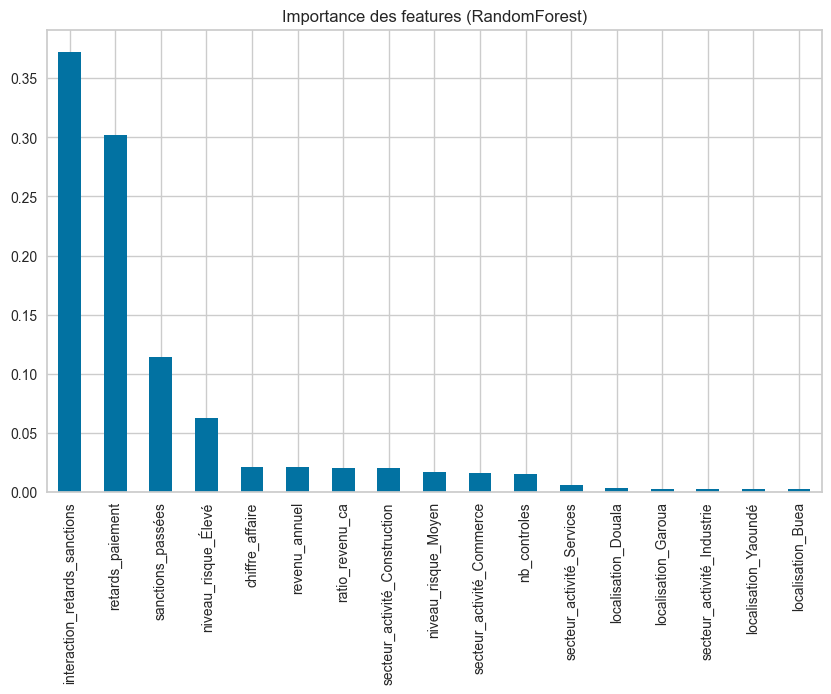

In [21]:
# Importance des features
feat_importance = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feat_importance.plot(kind='bar')
plt.title("Importance des features (RandomForest)")
plt.show()

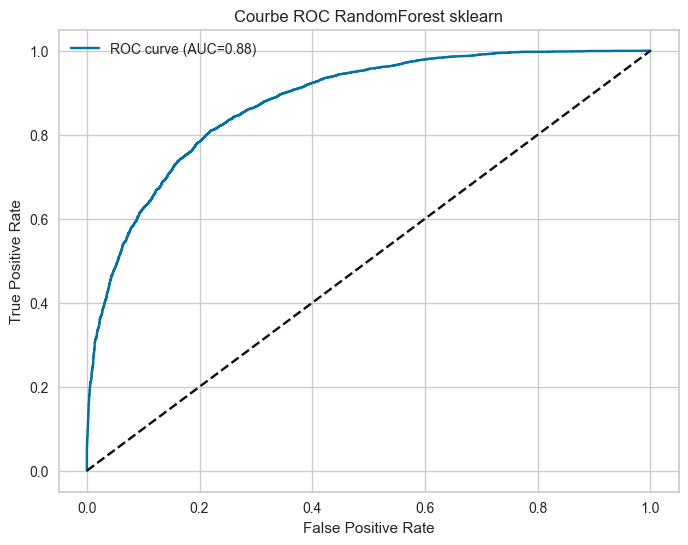

In [22]:
# 13. Optimisation seuil classification avec la courbe ROC
y_pred_proba = rf_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC RandomForest sklearn')
plt.legend()
plt.show()

In [23]:
# Calcul meilleur seuil maximisant F1
f1_scores = []
for thresh in thresholds:
    preds_thresh = (y_pred_proba > thresh).astype(int)
    report = classification_report(y_test, preds_thresh, output_dict=True, zero_division=0)
    f1_scores.append(report['1']['f1-score'])
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Seuil optimal max F1-score : {best_thresh:.3f}")

Seuil optimal max F1-score : 0.505


Classification Report avec seuil optimal 0.505 :
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      6784
           1       0.74      0.81      0.77      5216

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.80      0.79      0.79     12000



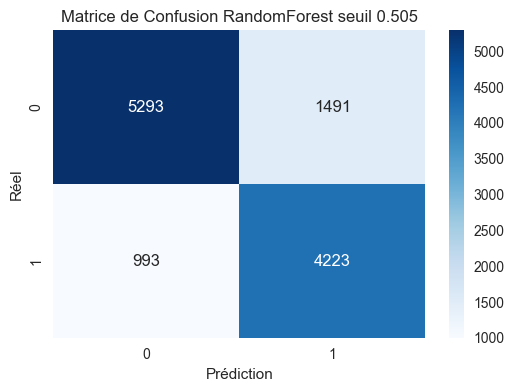

In [24]:
# Évaluation avec seuil optimal
y_pred_opt = (y_pred_proba > best_thresh).astype(int)
print(f"Classification Report avec seuil optimal {best_thresh:.3f} :")
print(classification_report(y_test, y_pred_opt, zero_division=0))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de Confusion RandomForest seuil {best_thresh:.3f}")
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

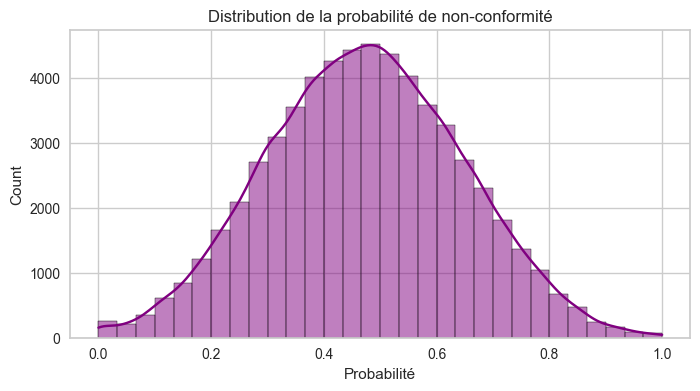

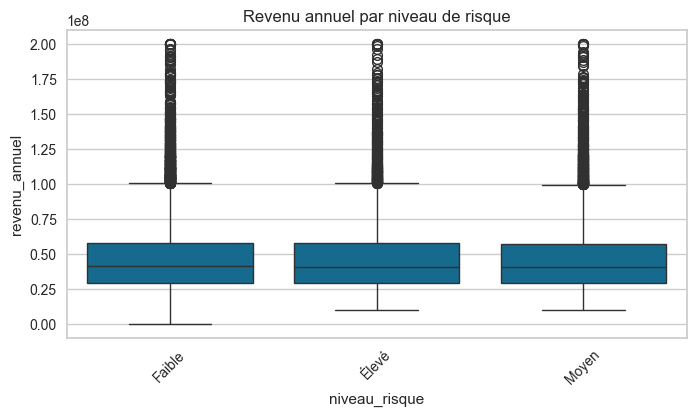

In [25]:
# 14. Visualisation supplémentaire
plt.figure(figsize=(8, 4))
sns.histplot(df['prob_non_conformité'], bins=30, kde=True, color='purple')
plt.title("Distribution de la probabilité de non-conformité")
plt.xlabel("Probabilité")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='niveau_risque', y='revenu_annuel', data=df)
plt.title("Revenu annuel par niveau de risque")
plt.xticks(rotation=45)
plt.show()

In [26]:
# 15. Fonction de prédiction sklearn avec artefacts enregistrés
def predict_with_artifacts(input_dict, threshold=best_thresh):
    with open("encoded_columns.json", "r") as f:
        encoded_cols = json.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("model_sklearn.pkl", "rb") as f:
        model = pickle.load(f)
    
    input_df = pd.DataFrame([input_dict])
    input_df['ratio_revenu_ca'] = input_df['revenu_annuel'] / input_df['chiffre_affaire'].replace(0, np.nan)
    input_df['ratio_revenu_ca'] = input_df['ratio_revenu_ca'].fillna(df['ratio_revenu_ca'].median())
    input_df['interaction_retards_sanctions'] = input_df['retards_paiement'] * input_df['sanctions_passées']
    
    input_encoded = pd.get_dummies(input_df, columns=['secteur_activité', 'localisation', 'niveau_risque'], drop_first=True)
    for col in encoded_cols:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    input_encoded = input_encoded[encoded_cols]
    input_scaled = scaler.transform(input_encoded)
    
    proba = model.predict_proba(input_scaled)[0][1]
    pred = int(proba > threshold)
    return pred, proba

# Exemple d'utilisation sklearn
example_input = {
    'revenu_annuel': 50000,
    'retards_paiement': 2,
    'sanctions_passées': 1,
    'secteur_activité': 'commerce',
    'chiffre_affaire': 100000,
    'localisation': 'paris',
    'nb_controles': 3,
    'niveau_risque': 'moyen'
}
pred_sk, proba_sk = predict_with_artifacts(example_input)
print(f"Prédiction sklearn : {pred_sk}, Probabilité : {proba_sk:.3f}")

Prédiction sklearn : 0, Probabilité : 0.147


# -----------------------------------------------
# 16. Intégration PyCaret pour automatisation
# -----------------------------------------------

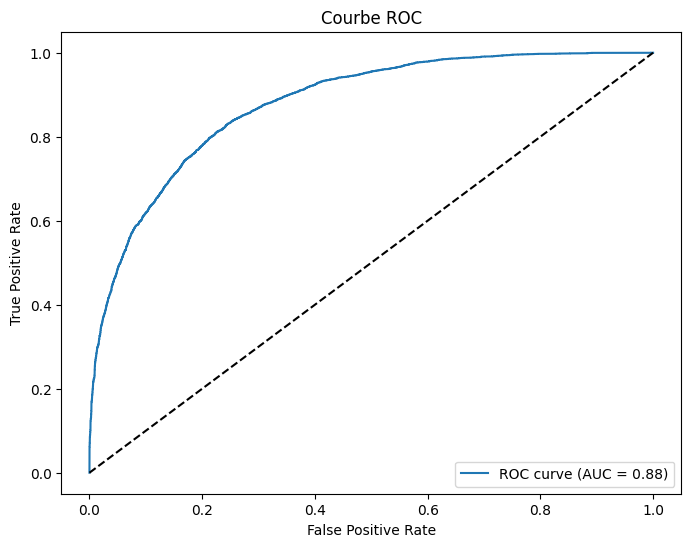

In [22]:
# 📊 Optimisation du seuil avec courbe ROC
y_pred_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Sélection du seuil optimal pour maximiser le F1-score
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True, zero_division=0)
    f1_scores.append(report['1']['f1-score'])
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Seuil optimal pour F1-score : {optimal_threshold:.2f}")

Seuil optimal pour F1-score : 0.47


In [24]:
# Évaluation avec le seuil optimal
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print(f"Classification Report avec seuil optimal {optimal_threshold:.2f} :")
print(classification_report(y_test, y_pred_optimal, zero_division=0))

Classification Report avec seuil optimal 0.47 :
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      6784
           1       0.72      0.84      0.77      5216

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.80      0.79      0.79     12000



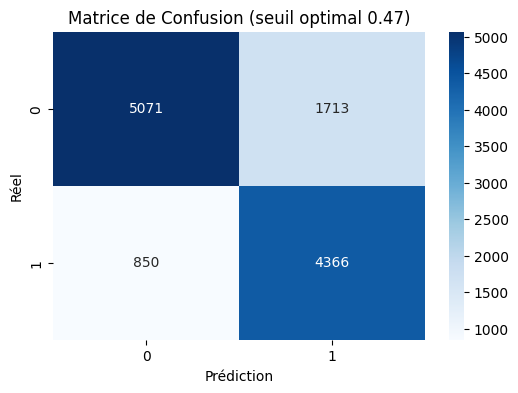

In [25]:
# Matrice de confusion avec seuil optimal
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de Confusion (seuil optimal {optimal_threshold:.2f})")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

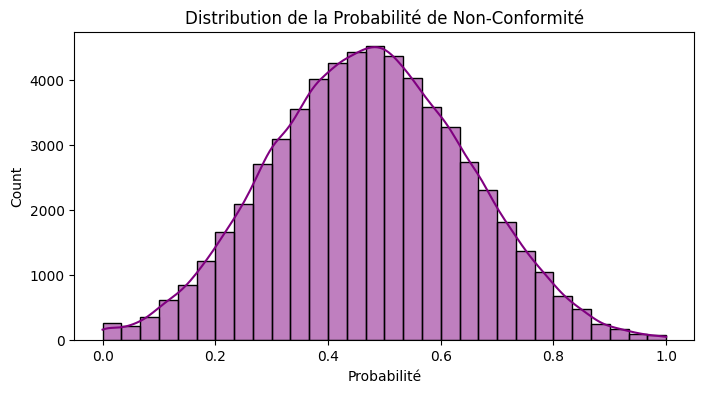

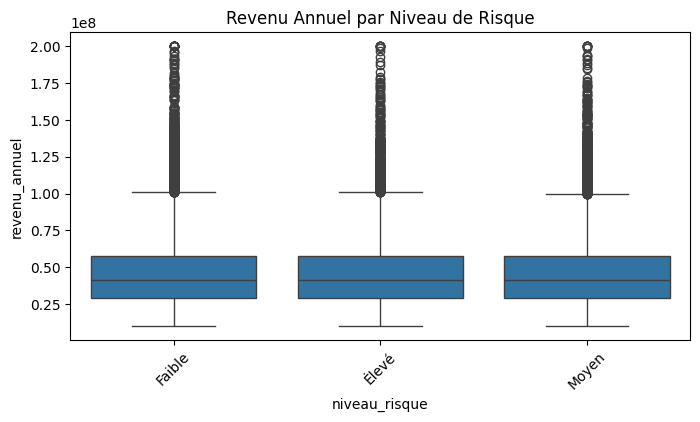

In [26]:
# 📊 Visualisations supplémentaires
plt.figure(figsize=(8, 4))
sns.histplot(df['prob_non_conformité'], bins=30, kde=True, color="purple")
plt.title("Distribution de la Probabilité de Non-Conformité")
plt.xlabel("Probabilité")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='niveau_risque', y='revenu_annuel', data=df)
plt.title("Revenu Annuel par Niveau de Risque")
plt.xticks(rotation=45)
plt.show()

In [27]:
# 🔍 Fonction de prédiction avec artefacts
def predict_with_artifacts(input_data_dict, threshold=optimal_threshold):
    with open("encoded_columns.json", "r") as f:
        encoded_cols = json.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("model_sklearn.pkl", "rb") as f:
        model = pickle.load(f)

    input_df = pd.DataFrame([input_data_dict])
    input_df['ratio_revenu_ca'] = input_df['revenu_annuel'] / input_df['chiffre_affaire'].replace(0, np.nan)
    input_df['ratio_revenu_ca'] = input_df['ratio_revenu_ca'].fillna(df['ratio_revenu_ca'].median())
    input_df['interaction_retards_sanctions'] = input_df['retards_paiement'] * input_df['sanctions_passées']
    
    input_df_encoded = pd.get_dummies(input_df)
    for col in encoded_cols:
        if col not in input_df_encoded.columns and col != "prob_non_conformité":
            input_df_encoded[col] = 0
    input_df_encoded = input_df_encoded[encoded_cols[:-1]]

    input_scaled = scaler.transform(input_df_encoded)
    pred = (model.predict_proba(input_scaled)[:, 1] > threshold).astype(int)[0]
    proba = model.predict_proba(input_scaled)[0][1]
    return pred, proba



In [ ]:
# On prépare un dataframe propre avec colonnes d’origine + features + target
df_pycaret = df.drop(columns=['prob_non_conformité']).copy()

# La target est déjà binarisée dans 'target'
# On peut demander à PyCaret de faire toute l’imputation, encodage, scaling, rééquilibrage

clf_pycaret = setup(
    data=df_pycaret,
    target='target',
    numeric_imputation=True,
    categorical_features=['secteur_activité', 'localisation', 'niveau_risque'],
    normalize=True,
    transformation=True,
    fix_imbalance=True,
    session_id=42,
    verbose=False
)


# Compare et sélectionne le meilleur modèle selon F1-score
best_model = compare_models(sort='F1')
print("Meilleur modèle PyCaret :")
print(best_model)

# Entraînement final sur tout le dataset
final_model = finalize_model(best_model)

# Évaluation interactive (affiche en notebook)
evaluate_model(final_model)

# Prédiction sur nouvel échantillon (même exemple)
sample_df = pd.DataFrame([example_input])
sample_df['ratio_revenu_ca'] = sample_df['revenu_annuel'] / sample_df['chiffre_affaire'].replace(0, np.nan)
sample_df['ratio_revenu_ca'] = sample_df['ratio_revenu_ca'].fillna(df_pycaret['ratio_revenu_ca'].median())
sample_df['interaction_retards_sanctions'] = sample_df['retards_paiement'] * sample_df['sanctions_passées']
predictions = predict_model(final_model, data=sample_df)
print(predictions.columns)
print(predictions.head())



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8008,0.8862,0.7703,0.7729,0.7716,0.5950,0.5950,2.3370
gbc,Gradient Boosting Classifier,0.8007,0.8856,0.7698,0.7731,0.7714,0.5948,0.5949,5.3280
ada,Ada Boost Classifier,0.7998,0.8850,0.7728,0.7698,0.7713,0.5932,0.5933,2.2100
ridge,Ridge Classifier,0.7993,0.8848,0.7720,0.7693,0.7706,0.5923,0.5923,1.1330
lda,Linear Discriminant Analysis,0.7993,0.8848,0.7720,0.7693,0.7706,0.5923,0.5923,1.1790
lightgbm,Light Gradient Boosting Machine,0.7997,0.8850,0.7620,0.7755,0.7686,0.5920,0.5921,2.4350
svm,SVM - Linear Kernel,0.7942,0.8787,0.7606,0.7667,0.7635,0.5814,0.5815,1.2340
nb,Naive Bayes,0.7819,0.8712,0.7749,0.7387,0.7563,0.5592,0.5598,1.1700
rf,Random Forest Classifier,0.7825,0.8665,0.7362,0.7589,0.7473,0.5566,0.5568,3.2580
et,Extra Trees Classifier,0.7710,0.8528,0.7250,0.7442,0.7344,0.5332,0.5334,2.8900


Meilleur modèle PyCaret :
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Index(['revenu_annuel', 'retards_paiement', 'sanctions_passées',
       'secteur_activité', 'chiffre_affaire', 'localisation', 'nb_controles',
       'niveau_risque', 'ratio_revenu_ca', 'interaction_retards_sanctions',
       'prediction_label', 'prediction_score'],
      dtype='object')
   revenu_annuel  retards_paiement  sanctions_passées secteur_activité  \
0          50000                 2                  1         commerce   

   chiffre_affaire localisation  nb_controles niveau_risque  ratio_revenu_ca  \
0           100000        paris             3         moyen              0.5   

   interaction_retards_sanctions  prediction_label  prediction_score  
0                              2                 0               1.0  


In [30]:
# Optionnel : sauvegarder le modèle PyCaret
import joblib
joblib.dump(final_model, "best_pycaret_model.pkl")

['best_pycaret_model.pkl']